In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
import os

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/dataset/"
filename = 'indian_birds.zip'
training_path = '/content/training_set/'

if not os.path.exists(training_path):
  from zipfile import ZipFile
  zippath = DRIVE_PATH + filename
  with ZipFile(zippath, 'r') as z:
    z.extractall(path='/content')
    print("Files Extracted")

Files Extracted


In [2]:
def create_dataset(img_path, batch_size, img_width, img_height, seed, subset):
    data = image_dataset_from_directory(
      img_path,
      labels='inferred',
      label_mode = "int",
      batch_size=batch_size,
      image_size=(img_height, img_width),
      shuffle=True,
      seed=seed,
      subset=subset,
      validation_split=0.2
  )
    return data


In [3]:
IMAGE_PATH = "/content/Birds_25/train"
VALID_PATH = "/content/Birds_25/valid"
batch_size = 4
img_width = 224
img_height = 224
num_channels = 3

SEED = 42

train_data = create_dataset(IMAGE_PATH, batch_size, img_width, img_height, SEED, 'training')
validation_data = create_dataset(VALID_PATH, batch_size, img_width, img_height, SEED, 'validation')

Found 30000 files belonging to 25 classes.
Using 24000 files for training.
Found 7500 files belonging to 25 classes.
Using 1500 files for validation.


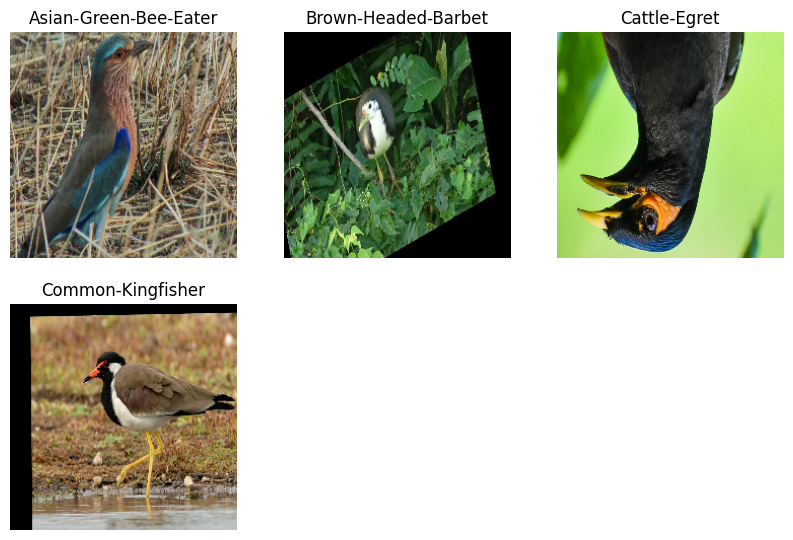

In [4]:
num_classes = 25
class_names = train_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")
    

In [5]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 224, 224, 3)
(4,)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)
#reshape_layer = tf.keras.layers.Reshape((-1, img_width, img_width, 1))

normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
#train_prep = normalized_ds.map(lambda x, y: (reshape_layer(x), y))

normalized_val = validation_data.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
#val_prep = val_ds.map(lambda x, y: (reshape_layer(x), y))

In [7]:
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val = normalized_val.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
def conv_block(x, filters, quantity):
    for i in range(quantity):
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    return x

def dense_block(x, neurons, quantity,activation="relu"):
    for i in range(quantity):
        x = tf.keras.layers.Dense(neurons, activation=activation)(x)
    return x

# the original vgg architecture, do not have batch mormalization and the last layer is a Dense(1000, activation="softmax")
# for our sample data our output will be a 25 dense layer
def vgg_16():
    input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    x = conv_block(input_layer, 64, 2)
    x = conv_block(x, 128, 2)
    x = conv_block(x, 256, 3)
    x = conv_block(x, 512, 3)
    x = conv_block(x, 512, 3)
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 4096, 2)
    x = dense_block(x, 25, 1, activation="softmax")
    return tf.keras.models.Model(input_layer, x, name="vgg16")

model = vgg_16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

# Training Vgg-16 From Scratch
If you want to train this model from scratch, here is the code to do so. For that you need a very good machine,
because the model has 134,404,416 trainable parameters.

In [8]:
EPOCHS = 75

checkpoint_path = "/content/drive/MyDrive/models/indianbirds/checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path +'model.{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=True,
    verbose=1,
    save_freq='epoch',
    period=1
)

def compile_vgg():
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"]
  )

def train():
  H = model.fit(normalized_ds,
                epochs=EPOCHS,
                validation_data=normalized_val,
                callbacks=[cp_callback],
  )
  return H

def plot_history(H):
  plt.figure(figsize=(10, 10))
  plt.plot( H.history["loss"], label="train_loss")
  plt.plot( H.history["accuracy"], label="train_acc")
  plt.plot( H.history["val_loss"], label="val_loss")
  plt.plot( H.history["val_accuracy"], label="val_acc")
  plt.title("Loss / accuracy evolution")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss / Accuracy")
  plt.ylim([0, 1])
  leg=plt.legend()


# Fine Tune Vgg-16
In this section will fine tune the Vgg model to suit our classification problem.


In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
for layer in vgg16_model.layers[:22]:
    layer.trainable = False
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten False
20 fc1 False
21 fc2 False
22 predictions True


In [11]:
def fine_tune(vgg):
  for layer in vgg16_model.layers[:22]:
    layer.trainable = False
    x = layer.output
  x = tf.keras.layers.Dense(25, activation="softmax")(x)
  return tf.keras.models.Model(inputs=vgg.input, outputs=x, name="vgg_fine_tuned")

model = fine_tune(vgg16_model)
model.summary()

Model: "vgg_fine_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)    

In [12]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
EPOCHS = 50
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"]
)

model.fit(normalized_ds, 
          validation_data=normalized_val,
          epochs=EPOCHS, 
          callbacks=[cp_callback]
)